<a href="https://colab.research.google.com/github/marinasemushina/-_-3/blob/main/DL_HW2_SemushinaMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Загрузим и посмотрим размер
images = np.load('images.npy')
labels = np.load('labels.npy')
images_sub = np.load('images_sub.npy')
print(f'images: {images.shape} of type {images.dtype}')
print(f'labels: {labels.shape} of type {labels.dtype}')
print(f'images_sub: {images_sub.shape} of type {images_sub.dtype}')

num_classes = 26 #количество классов
img_shape = (48, 48, 3) #размер изображений

images: (20000, 48, 48, 3) of type uint8
labels: (20000,) of type int64
images_sub: (50000, 48, 48, 3) of type uint8


In [17]:
# Разбиение набора на обучающую и валидационную выборки в соотношении 90/10
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size = 0.1, random_state = 42)
display(X_train.shape)
display(X_valid.shape)

(18000, 48, 48, 3)

(2000, 48, 48, 3)

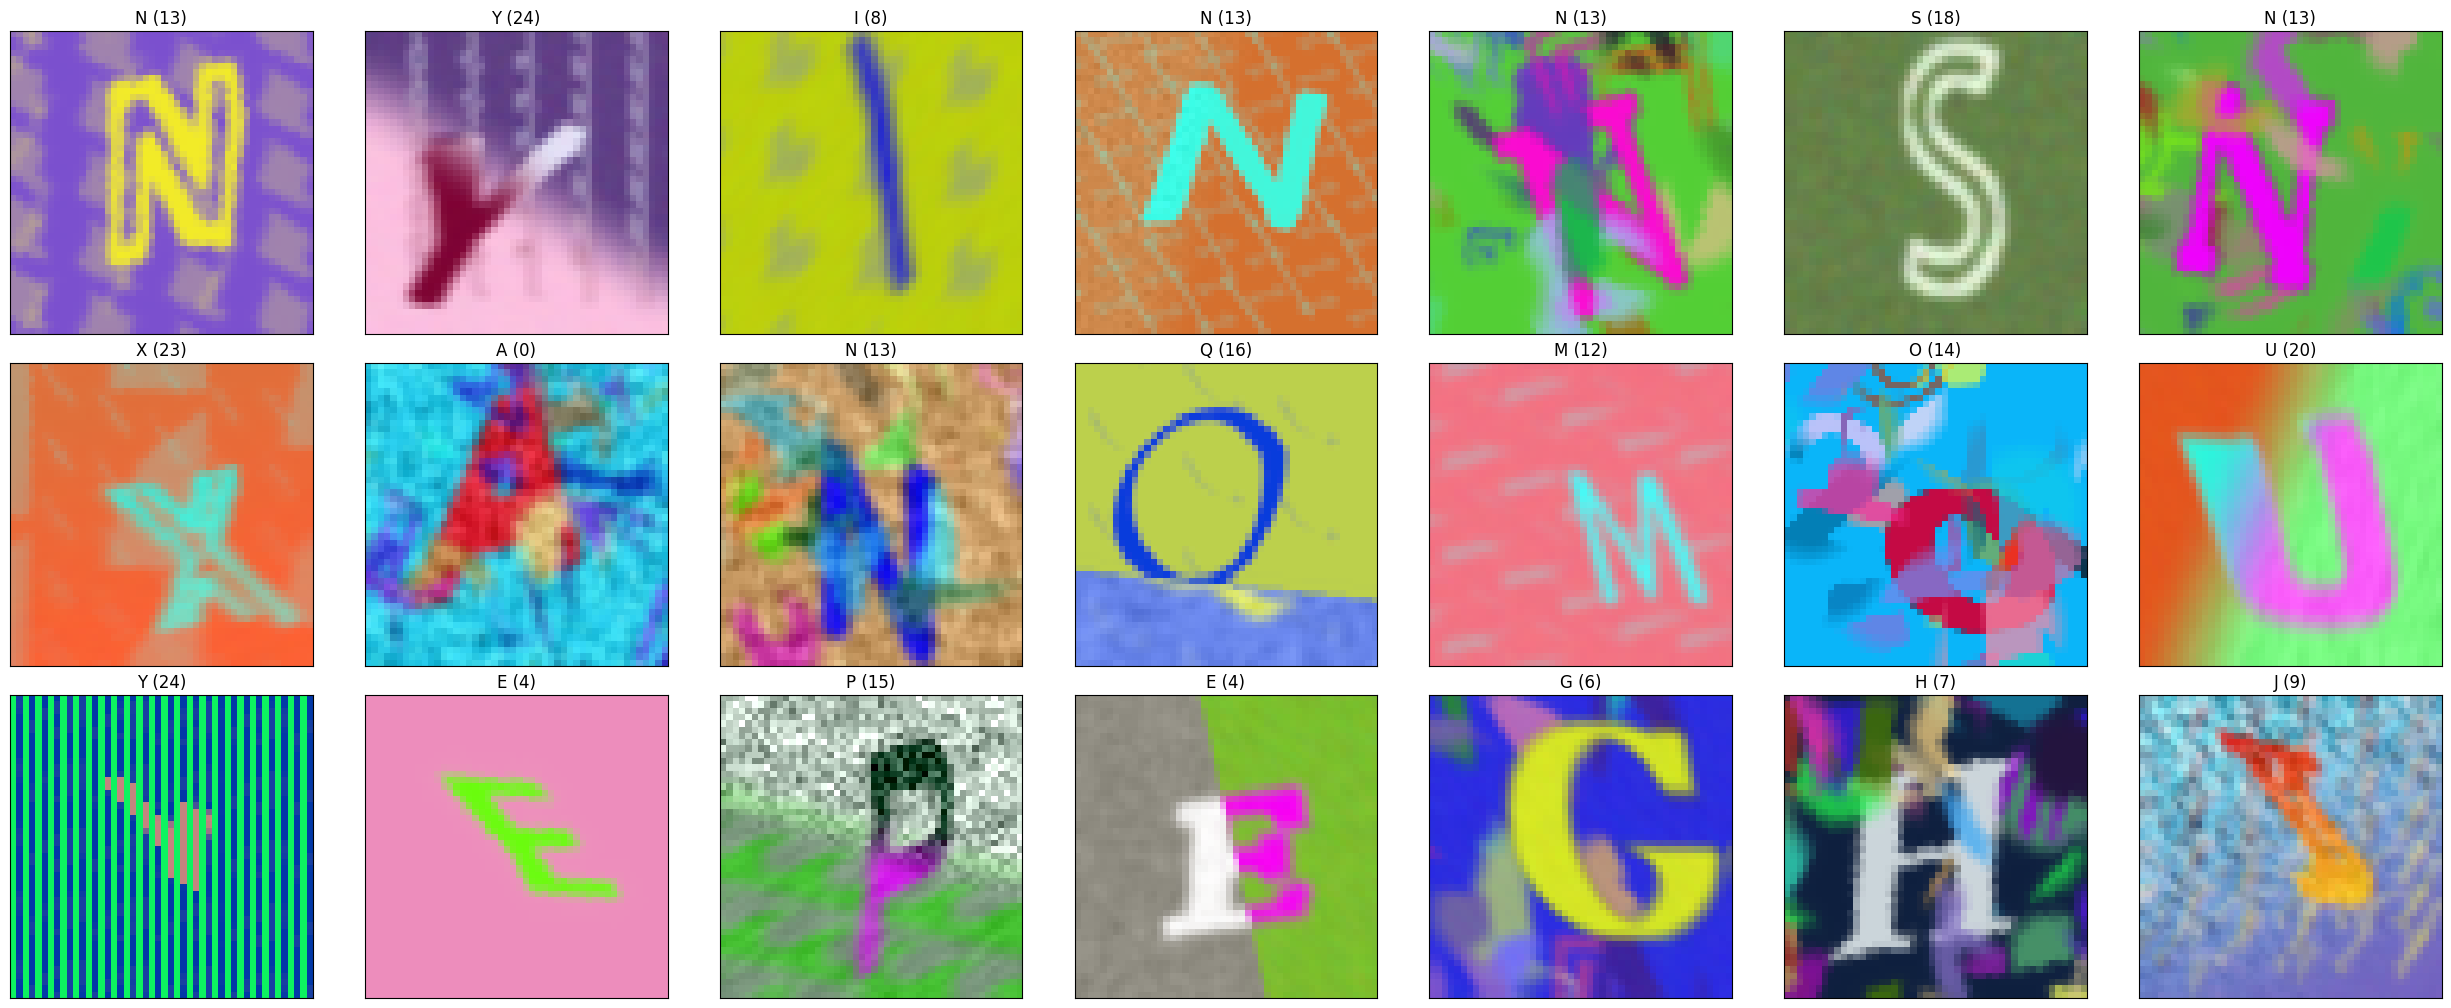

In [18]:
# Посмотрим как выглядят изображения
import matplotlib.pyplot as plt

def label_to_letter(label):
    return chr(ord('A') + label)

def show_symbols(images, labels = None, columns = 10, **kwargs):
    if labels is None: labels = [None] * len(images)
    rows = (len(images) - 1) // columns + 1
    fig = plt.figure(figsize = (25, (1.8 * 13 / columns) * rows))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(rows, columns, i + 1)
        imshow_kwargs = {'vmin': 0, 'vmax': 255}
        imshow_kwargs.update(kwargs)
        ax.imshow(img, **imshow_kwargs)
        if label is not None: ax.set_title(label)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    fig.tight_layout(pad = 0.5)
    plt.show()

display_count = 7*3
show_symbols(
    images[:display_count],
    labels = [f'{label_to_letter(x)} ({x})' for x in labels[:display_count]],
    columns = 7
)

In [19]:
# Нормализуем и закодируем в one-hot вектор
x_train_norm = X_train.astype('float32') / 255 - 0.5
x_valid_norm = X_valid.astype('float32') / 255 - 0.5

y_train_oh = keras.utils.to_categorical(y_train, 26)
y_valid_oh = keras.utils.to_categorical(y_valid, 26)
print(y_train_oh.shape, y_train_oh[:5])

(18000, 26) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [20]:
# Архитектура сети
K.clear_session()

model = M.Sequential()
model.add(L.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu',
                   input_shape=(48, 48, 3))) # 32 - кол-во фильтров, kernel_size - размер фильтра (3*3)
model.add(BatchNormalization())
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(rate=0.25))
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(L.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(rate=0.25))
model.add(L.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(L.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(rate=0.25))
model.add(L.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(rate=0.25))
model.add(L.Flatten())
model.add(L.Dense(1024, activation='relu'))
model.add(L.Dropout(rate=0.5))
model.add(L.Dense(512, activation='relu'))
model.add(L.Dropout(rate=0.5))
model.add(L.Dense(26, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,065,178 (15.51 MB)

 Trainable params: 4,063,322 (15.50 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [21]:
model.compile(
    loss='categorical_crossentropy',  # Функция потерь для минимизации - кросс-энтропия
    optimizer='adam',  # Оптимизатор
    metrics=['accuracy']  # Метрика оценки
)

In [22]:
history = model.fit(
                    x_train_norm,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=94,  # 94 прохода по датасету
                    validation_data=(x_valid_norm, y_valid_oh)
                    )

Epoch 1/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.0415 - loss: 3.9137 - val_accuracy: 0.0485 - val_loss: 3.2525
Epoch 2/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.0451 - loss: 3.2595 - val_accuracy: 0.0440 - val_loss: 3.2364
Epoch 3/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.0503 - loss: 3.2151 - val_accuracy: 0.0675 - val_loss: 3.1334
Epoch 4/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.0705 - loss: 3.1299 - val_accuracy: 0.1195 - val_loss: 2.8563
Epoch 5/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.1185 - loss: 2.8937 - val_accuracy: 0.3025 - val_loss: 2.1759
Epoch 6/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.2594 - loss: 2.3428 - val_accuracy: 0.5465 - val_loss: 1.3590
Epoch 7/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5135 - loss: 1.5027 - val_accuracy: 0.7705 - val_loss: 0.7630
Epoch 8/94
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6764 - loss: 1.0196 - val_

In [23]:
# Качество распознавания изображений на валидационной выборке
predicts = np.argmax(model.predict(x_valid_norm), axis = 1)
print('Valid Accuracy: ', accuracy_score(y_valid, predicts))

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Valid Accuracy:  0.9515


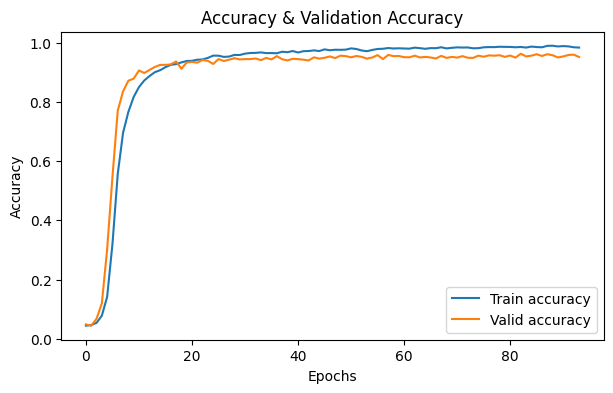

In [24]:
# График точности (accuracy)
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Valid accuracy')
plt.title('Accuracy & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [25]:
# загружаем шаблон submission
submission = pd.read_csv('sample_submission.csv')
submission.head()

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


In [26]:
images_sub = np.load('images_sub.npy')
images_sub_norm = images_sub.astype('float32') / 255 - 0.5

In [27]:
# Предсказание
test_predicts = model.predict(images_sub_norm)
test_labels = np.argmax(test_predicts,axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


In [29]:
# Запишем предсказанные метки в submission
submission['Category'] = test_labels
display(submission.head(10), submission.shape)
submission.to_csv('submission.csv', index = False)

,Id,Category
0,0,19
1,1,8
2,2,14
3,3,12
4,4,10
5,5,7
6,6,5
7,7,17
8,8,23
9,9,22


(50000, 2)